In [10]:
#imports
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.preprocessing.image import img_to_array, array_to_img
import pathlib

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense


In [11]:
class_names = ['NonDemented', 'Demented']
num_classes = len(class_names)
batch_size = 64
input_shape = (176, 208, 3)
AUTOTUNE = tf.data.experimental.AUTOTUNE

def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [12]:
#Non flipped images
#train_dir = pathlib.Path('../Project/Alzheimer_s Dataset_binary/train')
#test_dir = pathlib.Path('../Project/Alzheimer_s Dataset_binary/test')
#
#train_dataset = tf.keras.utils.image_dataset_from_directory(
#        train_dir,
#        labels='inferred',
#        class_names=class_names,
#        batch_size=batch_size,
#        image_size=input_shape[0:2])
#
#test_dataset = tf.keras.utils.image_dataset_from_directory(
#        test_dir,
#        labels='inferred',
#        class_names=class_names,
#        batch_size=batch_size,
#        image_size=input_shape[0:2])
#
#for images, labels, in train_dataset.take(1):
#    plt.imshow(images[0].numpy().astype('uint8'))
#    plt.title(class_names[labels[0]])
#    
#train_dataset = train_dataset.map(one_hot_label, num_parallel_calls=AUTOTUNE)
#test_dataset = test_dataset.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [13]:
######################## deprecated ########################

train_dir = pathlib.Path('../Project/Alzheimer_s Dataset_binary/train')
test_dir = pathlib.Path('../Project/Alzheimer_s Dataset_binary/test')

datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                       #rotation_range=10,
                                                       rescale=1./255
                                                       #brightness_range=(0.8,1.1),
                                                       #zoom_range=0.2,
                                                       #width_shift_range=0.1,
                                                       #height_shift_range=0.1
                                                      )

simple_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
        train_dir,
        classes=class_names,
        class_mode='categorical',
        shuffle=True,
        batch_size=batch_size,
        target_size=input_shape[0:2])

test_generator = simple_datagen.flow_from_directory(
        test_dir,
        classes=class_names,
        class_mode='categorical',
        shuffle=True,
        batch_size=batch_size,
        target_size=input_shape[0:2])

Found 5121 images belonging to 2 classes.
Found 1279 images belonging to 2 classes.


In [28]:
input_t = keras.Input(shape=input_shape)
         
         
ResNet = keras.applications.ResNet50(
        include_top=False,
        input_tensor=input_t,
        pooling=max)

for layers in ResNet.layers[:]:
    layers.trainable = False

model = keras.models.Sequential()
model.add(ResNet)

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dropout(0.6))

model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2,activation="softmax"))

In [29]:
epochs = 30
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
 
history = model.fit(train_generator, epochs=epochs,validation_data=test_generator)

Epoch 1/30
81/81 [==============================] - 17s 159ms/step - loss: 0.8072 - accuracy: 0.5507 - val_loss: 0.6832 - val_accuracy: 0.6247
Epoch 2/30
81/81 [==============================] - 12s 145ms/step - loss: 0.7132 - accuracy: 0.6171 - val_loss: 0.6709 - val_accuracy: 0.6247
Epoch 3/30
81/81 [==============================] - 12s 143ms/step - loss: 0.6927 - accuracy: 0.6274 - val_loss: 0.6812 - val_accuracy: 0.5113
Epoch 4/30
81/81 [==============================] - 12s 144ms/step - loss: 0.6567 - accuracy: 0.6518 - val_loss: 0.6557 - val_accuracy: 0.6411
Epoch 5/30
81/81 [==============================] - 12s 143ms/step - loss: 0.6295 - accuracy: 0.6659 - val_loss: 0.6724 - val_accuracy: 0.5465
Epoch 6/30
81/81 [==============================] - 12s 144ms/step - loss: 0.6218 - accuracy: 0.6671 - val_loss: 0.6343 - val_accuracy: 0.6513
Epoch 7/30
81/81 [==============================] - 12s 144ms/step - loss: 0.6106 - accuracy: 0.6798 - val_loss: 0.6244 - val_accuracy: 0.6521

In [147]:
score = model.evaluate(test_dataset,verbose=0)
print("Test loss:",score[0])
print("Test accuracy", score[1])

Test loss: 2.1780221462249756
Test accuracy 0.5652853846549988


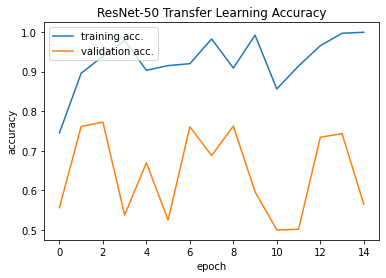

In [149]:
plt.title('ResNet-50 Transfer Learning Accuracy')

plt.plot(history.history['accuracy'], label = "training acc.")
plt.plot(history.history['val_accuracy'], label = "validation acc.")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training acc.', 'validation acc.'], loc='upper left')

#plt.savefig("../Project/Result/RESET2_MODEL_ACCURACY")
plt.show()